# Nonlinear model-predictive control (MPC) of a simulated air heater

Based on the MPC implementation performed by:
Author: Finn Haugen, USN

Link to Python source code:
http://techteach.no/control/python/mpc_airheater.py

Information about the air heater:
http://techteach.no/air_heater/


Process model:

    dT_dt = (1/time_constant)*((ambient_temperature - T) 
            + heat_transfer_coefficient*u(t-t_delay) + d);
    
where:
    
    - T [C] is outlet air temperature
    - ambient_temperature [C] is environmental (room) temp
    - u [V] is control signal to the heater
    - d [V] is a disturbance

Features:

    - Constraint on state (T)
    - Constraint on control signal (u)
    - Constraint on rate of change of control signal (du_dt)
    - Control signal blocking (or grouping) (u)
    - An Extended Kalman Filter which estimates an input disturbance.

Stop time is set with t_stop. Default: 300 s.

Toggle between continuous (online) plot and batch (offline) plot with 
variable cont_plot:

    cont_plot = 1 = continuous (online) plot.

    cont_plot = 0 = batch (offline) plot.

If continuous plot, execute the socalled magic command
%matplotlib auto 
in console which will show plot in an external window.

Originally implemented in Python 3.7.

In [56]:
# Imports - MPC
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize
import time
from tqdm.notebook import tqdm

# Imports - FMU
from fmpy import read_model_description, extract
from fmpy.fmi2 import FMU2Slave
from fmpy.util import plot_result, download_test_file
import shutil

# Timing of the code
t0 = time.time()

## Definition of functions
Includes two functions:

fun_mpc_objective_airheater(u)

    - Input = u

    - Return = total_cost

fun_mpc_constraints_airheater

    - Input = u

    - Return = [geq_zero_equiv_to_T_upperbound_constr, 
                     geq_zero_equiv_to_T_lowerbound_constr, 
                     geq_zero_equiv_to_du_dt_upperbound_constr, 
                     geq_zero_equiv_to_du_dt_lowerbound_constr]

## Import and setup of FMU

In [57]:
fmu_filename = 'AirHeater.fmu'

# read the FMU model description
model_description = read_model_description(fmu_filename)

# collect the value references from the FMU
vrs = {}
for variable in model_description.modelVariables:
    vrs[variable.name] = variable.valueReference

# get the value references for the variables we want to get/set
fmu_ControlSignal_Input = vrs['u_ext']                 # Control signal
fmu_AmbientTemperature_Input = vrs['T_amb_ext']        # Ambient air temperature
fmu_OutputTemperature_Output = vrs['T_Out_ext']        # Output temperature from air heater

# extract the FMU
unzipdir = extract(fmu_filename)

fmu = FMU2Slave(guid = model_description.guid,
                unzipDirectory=unzipdir,
                modelIdentifier=model_description.coSimulation.modelIdentifier,
                instanceName='instance1')



## Setup of process and simulation parameters

In [58]:
# Process params
heat_transfer_coefficient = 3.5  # [deg C/V]
time_constant = 23.0  # [s]
t_delay = 3.0  # [s]

# Ambient temperature
ambient_temperature = 28.0  # [deg C]

#%% Time settings:
sampling_time = 0.5  # Time-step [s]
t_pred_horizon = 8.0  # [s]

num_predictions = int(t_pred_horizon/sampling_time)
t_start = 0.0  # [s]
t_stop = 300.0  # [s]
N_sim = int((t_stop-t_start)/sampling_time) + 1

#%% MPC costs
cost_error = 1.0
cost_rate_of_change = 20.0  # [(L/s)/min]
mpc_costs = np.array([cost_error, cost_rate_of_change])

#%% MPC control blocking (or grouping)

# Number of blocks of control signal:
num_blocks_u = 3
# Number of samples in each control block:
num_samples_in_blocks = int(np.ceil(num_predictions/num_blocks_u))

# Change of disturbance
t_disturbance = 50  # [s]
d_const = -2  # [V]

## Setup and build array for changes in temperature setpoint in relation to time

In [59]:
#%% Defining sequence for T setpoint
T_sp_const = 30.0  # [C]
Ampl_step = 2.0  # [C]
Slope = -0.04  # [C/s]
Ampl_sine = 1.0  # [C]
t_period = 50.0  # [s]

t_const_start = t_start
t_const_stop = 100
t_step_start = t_const_stop
t_step_stop = 150
t_ramp_start = t_step_stop
t_ramp_stop = 200
t_sine_start = t_ramp_stop
t_sine_stop = 250
t_const2_start = t_sine_stop
t_const2_stop = t_stop

t = np.linspace(t_start, t_stop, N_sim)
T_sp_array = np.linspace(t_start, t_stop, N_sim)*0

for k in range(0, N_sim):
    if t[k] >= t_const_start and t[k] < t_const_stop:
        T_sp_array[k] = T_sp_const
    if t[k] >= t_step_start and t[k] < t_step_stop:
        T_sp_array[k] = T_sp_const + Ampl_step
    if t[k] >= t_ramp_start and t[k] < t_ramp_stop:
        T_sp_array[k] = T_sp_const + Ampl_step + Slope*(t[k]-t_ramp_start)
    if t[k] >= t_sine_start and t[k] < t_sine_stop:
        T_sp_array[k] = T_sp_const + Ampl_sine*np.sin(2*np.pi*(1/t_period)*(t[k]-t_sine_start))
    if t[k] >= t_const2_start:
        T_sp_array[k] = T_sp_const

## Initialization of variables

In [60]:
#%% Initialization of time delay
u_init = 0.0  # [V]
num_delay = int(round(t_delay/sampling_time)) + 1
delay_array = np.zeros(num_delay) + u_init

#%% Initial state of process
T_k = 28.0  # [C]

#%% Initialization of Kalman Filter
# Initial state:
T_est_pred_k = 28.0  # [C]
d_est_pred_k = 0.0  # [V]

estimated_temperature = T_est_pred_k
estimated_disturbance = d_est_pred_k

n_states = 2

# Initial pred state estim:
x_est_pred_k = np.array([[estimated_temperature, estimated_disturbance]]).T

# Initial covariance of pred estim error:
stdev_error_T = 0.01
P_est_error_T = (stdev_error_T**2)
stdev_est_error_d = 0.01
P_est_error_d = (stdev_est_error_d**2)
P_est_pred_k = np.diag([0.1*P_est_error_T,
                                  0.1*P_est_error_d])

In [61]:
#%% Tuning of Kalman Filter
stdev_w_T = 0.01
cov_w_T = stdev_w_T**2
stdev_w_d = 0.01
cov_w_d = stdev_w_d**2
Q = np.diag([1*cov_w_T, 1*cov_w_d])

stdev_v_T = 0.01
cov_v_T = stdev_v_T**2
R = np.diag([1*cov_v_T])

#%% Initial value of previous optimal value
u_opt_km1 = u_init

#%% Initial value of time delayed control signal
u_delayed_k = 2

#%% Defining arrays for plotting
t_plot_array = np.linspace(t_start, t_stop, N_sim-num_predictions)
T_sp_plot_array = np.zeros(N_sim-num_predictions) + T_sp_const 
T_plot_array = np.zeros(N_sim-num_predictions) + T_sp_const
T_plot_arrayFMU = np.zeros(N_sim-num_predictions)
T_est_plot_array = np.zeros(N_sim-num_predictions) + T_sp_const
T_env_plot_array = np.zeros(N_sim-num_predictions) + ambient_temperature
u_plot_array = np.zeros(N_sim-num_predictions) + 1.07 
u_plot_arrayFMU = np.zeros(N_sim-num_predictions) + 1.07  
du_opt_dt_plot_array = np.zeros(N_sim-num_predictions)
d_est_plot_array = np.zeros(N_sim-num_predictions) - 0.5

#%% Settings of optimizer
# Initial guessed optimal control sequence:
u_guess = np.zeros(num_blocks_u) + u_init

# Lower and upper limits of optim variable for use in SLSQP:
u_upperbound = 5
u_lowerbound = 0
bounds_u = np.zeros([num_blocks_u, 2])
bounds_u[:, 0] = u_lowerbound
bounds_u[:, 1] = u_upperbound

# Constraints:
T_upperbound = 31.0  # [C]
T_lowerbound = 27.0  # [C]
T_fun_constraint_array = np.zeros(num_predictions)

du_dt_upperbound = 0.25 #1 # 0.25  # [V/s]
du_dt_lowerbound = -0.25 #-1 # -0.25  # [V/s]
du_dt_fun_constraint_array = np.zeros(num_predictions)

#%% Selecting between continuous plot and batch plotting
# 0 = off = batch (offline) plot.
# 1 = on = continuous (online) plot. May use external
# figure window by executing %matplotlib auto in console.

cont_plot = 0
real_time_step = 0.01


In [62]:
# Start values in the FMU to be changed
start_vrs = [vrs['T_amb_ext'], vrs['T_Out_ext']]

# Update values for the starting point
start_values = [ambient_temperature, ambient_temperature]

# initialize - Needs to run before every time the simulation is performed
fmu.instantiate()
fmu.setupExperiment(startTime=t_start)

# set the start values
fmu.setReal(vr=start_vrs, value=start_values)
fmu.enterInitializationMode()
fmu.exitInitializationMode()

rows = []  # list to record the results

## For-loop for MPC of sim process incl Kalman Filter for both Pythhon model of air heater and imported FMU model of air heater

In [63]:
def calculate_mpc_objective(u_values):
    """
    Calculate the objective function for Model Predictive Control (MPC) in an air heater system.

    Parameters:
    - u_values (list or array): Control inputs for each prediction horizon.

    Returns:
    - float: The value of the total cost or performance index.
    """

    # Initialize variables
    u_at_each_time = np.array([])

    current_temperature = estimated_temperature
    current_disturbance = estimated_disturbance

    # Create an array of control inputs for each time step in the prediction horizon
    for ku in range(0, num_blocks_u):
        u_at_each_time = np.append(u_at_each_time,
                                   np.zeros(num_samples_in_blocks) + u_values[ku])

    previous_control_input = u_values[0]
    total_cost = 0  # Updated variable name

    # Array to simulate time delay
    delay_array = np.zeros(num_delay) + u_values[0]

    # Simulation loop
    for k in (range(0, num_predictions)):

        current_control_input = u_at_each_time[k]
        setpoint_temperature = temperature_setpoints_for_mpc[k]

        # Time delay
        delayed_control_input = delay_array[-1]
        delay_array[1:] = delay_array[0:-1]
        delay_array[0] = current_control_input

        # Solving differential equation
        derivative_temperature = ((1 / time_constant) * ((ambient_temperature - current_temperature)
                                                         + heat_transfer_coefficient * (delayed_control_input + current_disturbance)))
        next_temperature = current_temperature + sampling_time * derivative_temperature

        # Updating objective function
        error_temperature = setpoint_temperature - current_temperature
        rate_of_change_control_input = (current_control_input - previous_control_input) / sampling_time
        total_cost += sampling_time * (cost_error * error_temperature**2 + cost_rate_of_change * rate_of_change_control_input**2)

        # Time shift
        current_temperature = next_temperature
        previous_control_input = current_control_input

    return total_cost


def mpc_constraints_airheater(control_inputs):
    """
    Calculate Model Predictive Control (MPC) constraints for an air heater system.

    Parameters:
    - control_inputs (array): Control inputs for each prediction horizon.

    Returns:
    - array: Array of constraints, ensuring they are greater than or equal to zero.
    """

    # Initialize control input array for each time step
    u_at_each_time = np.array([])

    # Initialize state variables
    current_temperature = estimated_temperature
    current_disturbance = estimated_disturbance

    for ku in range(0, num_blocks_u):
        u_at_each_time = np.append(u_at_each_time,
                                    np.zeros(num_samples_in_blocks) + control_inputs[ku])

    # Array to simulate time delay
    delay_array = np.zeros(num_delay) + control_inputs[0]

    # Arrays to store results
    T_constraint_array = np.zeros(num_predictions)
    du_dt_constraint_array = np.zeros(num_predictions)

    # Simulation loop
    for k in range(0, num_predictions):

        current_control_input = u_at_each_time[k]

        # Time delay
        delayed_control_input = delay_array[-1]
        delay_array[1:] = delay_array[0:-1]
        delay_array[0] = current_control_input

        # Solving differential equation
        derivative_temperature = ((1 / time_constant)
                                 * ((ambient_temperature - current_temperature)
                                    + heat_transfer_coefficient * (delayed_control_input + current_disturbance)))
        next_temperature = current_temperature + sampling_time * derivative_temperature

        # Rate of change of control input
        du_dt = (current_control_input - u_opt_km1) / sampling_time

        # Storing in arrays
        T_constraint_array[k] = current_temperature
        du_dt_constraint_array[k] = du_dt

        # Time shift
        current_temperature = next_temperature

    # Constraint calculations
    T_upperbound_constraint = T_upperbound - np.max(T_constraint_array)
    T_lowerbound_constraint = np.min(T_constraint_array) - T_lowerbound
    du_dt_upperbound_constraint = du_dt_upperbound - np.max(du_dt_constraint_array)
    du_dt_lowerbound_constraint = np.min(du_dt_constraint_array) - du_dt_lowerbound

    return np.array([T_upperbound_constraint, T_lowerbound_constraint,
                     du_dt_upperbound_constraint, du_dt_lowerbound_constraint])


## Main simulation loop

In [64]:
for time_step in tqdm(range(0, (N_sim - num_predictions))):
    
    # Current time
    current_time = t[time_step]
    t_plot_array[time_step] = current_time
    
    # ----------------------- FMU MODS -----------------------
    
    # Simulate the FMU model one step forward in time based on the general sampling time for the simulation
    fmu.doStep(currentCommunicationPoint=current_time, communicationStepSize=sampling_time)

    # Get the values for 'inputs' and 'outputs' from the FMU
    inputs, outputs = fmu.getReal([fmu_ControlSignal_Input, fmu_OutputTemperature_Output])
    
    # Append the results to an array for plotting
    rows.append((current_time, inputs, outputs))
    
    # --------------------------------------------------------
    # Kalman Filter for estimating T and d using meas of T.
    # These estimates are used by the MPC.
    # Note: The time-delayed u is used as a control signal here.

    # Matrices in linearized model:
    A_cont = np.array([[-1/time_constant, heat_transfer_coefficient/time_constant],
                       [0, 0]])
    C_cont = np.array([[1, 0]])
    A_disc = np.eye(n_states) + sampling_time * A_cont
    C_disc = C_cont

    # Kalman heat_transfer_coefficient:
    K_k = ((P_est_pred_k @ (C_disc.T))
           @ (np.linalg.inv(C_disc @ P_est_pred_k @ (C_disc.T) + R)))

    # Innovation process:
    e_est_k = T_k - estimated_temperature

    # Measurement-based correction of estimate = the applied estimate:
    T_est_corr_k = T_est_pred_k + K_k[0, 0] * e_est_k
    d_est_corr_k = d_est_pred_k + K_k[1, 0] * e_est_k

    # Applied estimated process meas:
    estimated_temperature = T_est_corr_k
    estimated_disturbance = d_est_corr_k

    # Prediction of state estimate for the next time-step:
    dT_est_corr_dt_k = ((1 / time_constant)
                        * ((ambient_temperature - T_est_corr_k)
                           + heat_transfer_coefficient * (u_delayed_k + d_est_corr_k)))
    dd_est_corr_dt_k = 0

    T_est_pred_kp1 = T_est_corr_k + sampling_time * dT_est_corr_dt_k
    d_est_pred_kp1 = d_est_corr_k + sampling_time * dd_est_corr_dt_k

    # Auto-covariance of error of corrected estimate:
    P_est_corr_k = (np.eye(n_states)
                    - K_k @ C_disc) @ P_est_pred_k

    # Auto-covariance of error of predicted estimate of the next time step:
    P_est_kp1 = A_disc @ P_est_corr_k @ (A_disc.T) + Q

    # Time shift:
    P_est_pred_k = P_est_kp1

    T_est_pred_k = T_est_pred_kp1
    d_est_pred_k = d_est_pred_kp1

    # Storage for plotting:
    T_est_plot_array[time_step] = estimated_temperature

    # Setpoint array to optimizer:
    temperature_setpoints_for_mpc = T_sp_array[time_step:time_step + num_predictions]
    T_sp_plot_array[time_step] = T_sp_array[time_step]

    # Calculating optimal control sequence:
    ineq_cons = {'type': 'ineq',
                 'fun': mpc_constraints_airheater}  # >= 0 constraints
    res = minimize(calculate_mpc_objective,
                   u_guess,
                   method='SLSQP',
                   constraints=[ineq_cons],
                   options={'ftol': 1e-9, 'disp': False},
                   bounds=bounds_u)

    u_opt = res.x

    # SET FMU optimized control signal
    fmu.setReal([fmu_ControlSignal_Input], [u_opt[0]])

    # Optim solution used as guessed sol. in the next iteration:
    u_guess = u_opt

    # Optimal control signal (sample) to be applied:
    u_opt_k = u_opt[0]

    u_plot_array[time_step] = u_opt_k  # Storage for plotting
    u_plot_arrayFMU[time_step] = inputs  # Store FMU control signal gathered from FMU
    
    # Rate of change of u:
    du_opt_dt_k = (u_opt_k - u_opt_km1) / sampling_time
    du_opt_dt_plot_array[time_step] = du_opt_dt_k
    
    # Time shift:
    u_opt_km1 = u_opt_k

    # Time delay:
    u_delayed_k = delay_array[-1]
    delay_array[1:] = delay_array[0:-1]
    delay_array[0] = u_opt_k

    # Solving differential equation:
    dT_dt_k = ((1 / time_constant)
               * ((ambient_temperature - T_k) + heat_transfer_coefficient * (u_delayed_k)))
    T_kp1 = T_k + sampling_time * dT_dt_k

    # Storage for plotting:
    T_plot_array[time_step] = T_k
    T_plot_arrayFMU[time_step] = outputs

    # Time shift:
    T_k = T_kp1

# Stop the FMU
fmu.terminate()
fmu.freeInstance()

# clean up
shutil.rmtree(unzipdir, ignore_errors=True) 

  0%|          | 0/585 [00:00<?, ?it/s]

## Plotting

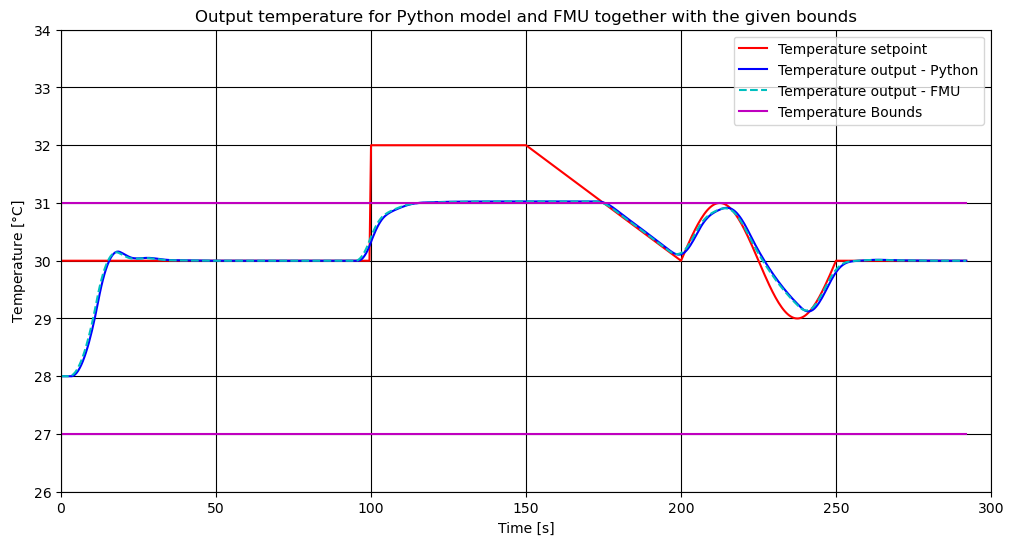

In [65]:
plt.figure(figsize=(12,6))

plt.grid(which='both', color='k')
plt.ylim(26, 34)
plt.xlim(t_start, t_stop)
plt.xlabel('Time [s]')
plt.ylabel((r'Temperature [$\degree$C]'))
plt.plot(t_plot_array, T_sp_plot_array, 'r',
         t_plot_array, T_plot_array, 'b',
         t_plot_array, T_plot_arrayFMU, 'c--',
         t_plot_array, T_plot_array*0 + T_upperbound, 'm',
         t_plot_array, T_plot_array*0 + T_lowerbound, 'm')
plt.legend(('Temperature setpoint', 'Temperature output - Python', 
            'Temperature output - FMU', 'Temperature Bounds'),
           loc="best")
plt.title('Output temperature for Python model and FMU together with the given bounds')
    
plt.savefig('plots/MPCTemperatureOutputPlot.png', dpi=300, bbox_inches='tight')    

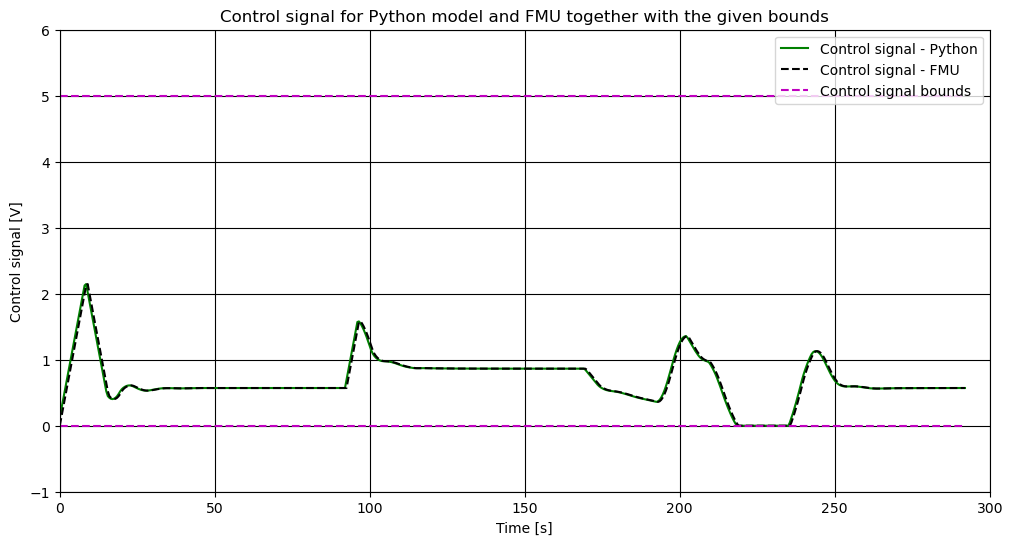

In [66]:
plt.figure(figsize=(12,6))
plt.grid(which='both', color='k')
plt.ylim(-1, 6)
plt.xlim(t_start, t_stop)
plt.xlabel('Time [s]')
plt.ylabel('Control signal [V]')
plt.plot(t_plot_array, u_plot_array, 'g',
             t_plot_array, u_plot_arrayFMU, 'k--',
             t_plot_array, u_plot_array*0 + u_upperbound, 'm--',
             t_plot_array, u_plot_array*0 + u_lowerbound, 'm--')
plt.legend(('Control signal - Python', 'Control signal - FMU', 'Control signal bounds'),
               loc='upper right')

plt.title('Control signal for Python model and FMU together with the given bounds')

plt.savefig('plots/MPCControlSignalPlot.png', dpi=300, bbox_inches='tight')    

In [67]:
# Stop timer and print total duration
t1 = time.time()
print ("Total simulation time was: ", t1-t0)

Total simulation time was:  26.79354214668274


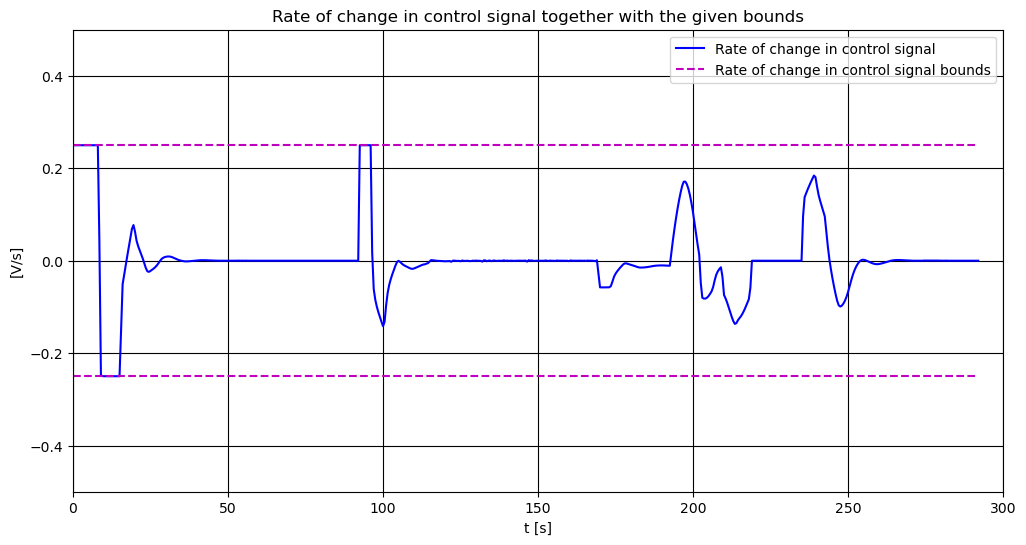

In [68]:
plt.figure(figsize=(12,6))
plt.grid(which='both', color='k')
plt.ylim(-0.5, 0.5)
plt.xlim(t_start, t_stop)
plt.xlabel('t [s]')
plt.ylabel('[V/s]')
plt.plot(t_plot_array, du_opt_dt_plot_array, 'b',
             t_plot_array, du_opt_dt_plot_array*0 
             + du_dt_upperbound, 'm--',
             t_plot_array, du_opt_dt_plot_array*0 
             + du_dt_lowerbound, 'm--')
plt.legend(('Rate of change in control signal', 'Rate of change in control signal bounds'),
               loc='best')

plt.title('Rate of change in control signal together with the given bounds')

plt.savefig('plots/MPCRateOfChange.png', dpi=300, bbox_inches='tight') 